In [1]:
%pylab inline
import pandas as pd

from dataManager import DataManager
from model import ModelManager as manager

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as mse

import plotly.graph_objects as go

Populating the interactive namespace from numpy and matplotlib


In [2]:
prods = data = DataManager().products.drop_duplicates().copy()
prods['AREA'] = prods.ANCHO * prods.FONDO

data = DataManager().sales_ref_month_sin_ventas_mayores()
data['DATE'] = data['ANIO'].astype(str) + '-' + data['MES'].astype(str).str.zfill(2)

df = data.pivot_table(index='REF',columns=['DATE','ANIO','MES','TIENDA'],values='CANTIDAD',aggfunc='sum').reset_index()
df = pd.melt(df,id_vars='REF')

df = df.sort_values(['REF','DATE'])
df = df.rename(columns={'value':'CANTIDAD'})
df = df.reset_index(drop=True).fillna(0)

df = df.merge(data.drop(columns=['ANIO','MES','CANTIDAD']).groupby(['REF','DATE','TIENDA']).mean(),on=['REF','DATE','TIENDA'],how='left',validate='1:1')
df = df[['REF','TIENDA','DATE','ANIO','MES','CANTIDAD','PRECIO','DESCUENTO(%)','F_COVID']]
df = df.fillna(0)

df = df.merge(prods,on='REF',validate='m:1')
df = df.sort_values(['ANIO','MES']).reset_index(drop=True)

In [5]:
df.columns

Index(['REF', 'TIENDA', 'DATE', 'ANIO', 'MES', 'CANTIDAD', 'PRECIO',
       'DESCUENTO(%)', 'F_COVID', 'ITEM', 'DESCRIPCION', 'CATEGORIA',
       'SUBCATEGORIA', 'VIGENCIA', 'ORIGEN', 'ESTILO', 'MATERIAL', 'ACABADO',
       'PUESTOS', 'COLOR', 'ANCHO', 'ALTO', 'FONDO', 'DESC_LARGA',
       'SUBCATEGORIA_POS', 'COLOR_POS', 'MATERIAL_POS', 'AREA'],
      dtype='object')

In [6]:
num_var=['AREA','ALTO','DESCUENTO(%)','PRECIO','CANTIDAD']
x_num=df[num_var[:-1]].astype('float')

cat_var=[
    'ANIO', 'MES','TIENDA', 'PUESTOS', 'COLOR_POS', 'SUBCATEGORIA_POS', 'ESTILO', 'F_COVID' ,'CATEGORIA','VIGENCIA','ORIGEN','MATERIAL_POS','ACABADO'
]
x_cat=df[cat_var].astype('category')
x_cat_dummies=pd.get_dummies(x_cat)

y = df['CANTIDAD']

scaler = MinMaxScaler()
x_num_norm = scaler.fit_transform(x_num)
x = np.append(x_num_norm,x_cat_dummies,axis=1)

#split data till januar 2021

index = df[(df.ANIO==2021)].index[0]
date_index=df[(df.ANIO==2021)]['DATE'].values[0]
date_indebef=df.loc[index-1]['DATE']
date_indeaf=df.loc[index+1]['DATE']

x_train = x[:index]
y_train = y[:index]
x_test = x[index:]
y_test = y[index:]

In [7]:
x.shape

(382165, 97)

In [8]:
%%time
model = GradientBoostingRegressor(**{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 300})
model.fit(x_train,y_train)

Wall time: 3min 51s


GradientBoostingRegressor(max_depth=2, n_estimators=300)

In [9]:
list(zip(x_num.columns.append(x_cat_dummies.columns),model.feature_importances_))

[('AREA', 0.00022804568963031625),
 ('ALTO', 0.0033063452541816055),
 ('DESCUENTO(%)', 0.10488233308985917),
 ('PRECIO', 0.7122739373109741),
 ('ANIO_2019', 0.0),
 ('ANIO_2020', 0.0),
 ('ANIO_2021', 0.0),
 ('MES_1', 0.0),
 ('MES_2', 0.0),
 ('MES_3', 2.832897672398523e-05),
 ('MES_4', 1.71123938918684e-05),
 ('MES_5', 0.0),
 ('MES_6', 9.678883481569793e-05),
 ('MES_7', 0.0),
 ('MES_8', 0.00011084666946215597),
 ('MES_9', 0.0),
 ('MES_10', 9.86178022194076e-05),
 ('MES_11', 0.0004732917377829756),
 ('MES_12', 0.0),
 ('TIENDA_ADMINISTRACION', 0.0),
 ('TIENDA_PAGINA WEB FIOTTI', 0.0010673251810074667),
 ('TIENDA_PUNTO DE VENTA AV 68', 0.01701710950175237),
 ('TIENDA_PUNTO DE VENTA BUCARAMANGA', 0.0),
 ('TIENDA_PUNTO DE VENTA CALI', 5.004234411519926e-06),
 ('TIENDA_PUNTO DE VENTA CALLE 134', 0.00012014610651868214),
 ('TIENDA_PUNTO DE VENTA CENTRO MAYOR', 0.0038816540243328565),
 ('TIENDA_PUNTO DE VENTA LAURELES', 0.0),
 ('TIENDA_PUNTO DE VENTA PLAZA CENTRAL', 0.0),
 ('TIENDA_PUNTO DE VENT

In [10]:
mse(model.predict(x_test),y_test)

0.13669260194549676

In [11]:
mse(model.predict(x_train),y_train)

0.19971034949313615

In [13]:
df['PREDICTED'] = model.predict(np.concatenate([x_train,x_test],axis=0)).round()
df_train=df[:index]
df_test=df[index:]
res = df.groupby(['REF','DATE']).sum().reset_index()
res_train=df_train.groupby(['REF','DATE']).sum().reset_index()
res_test=df_test.groupby(['REF','DATE']).sum().reset_index()

In [14]:
mse(df_train.PREDICTED,df_train.CANTIDAD) #crece por el round

0.20473632512738657

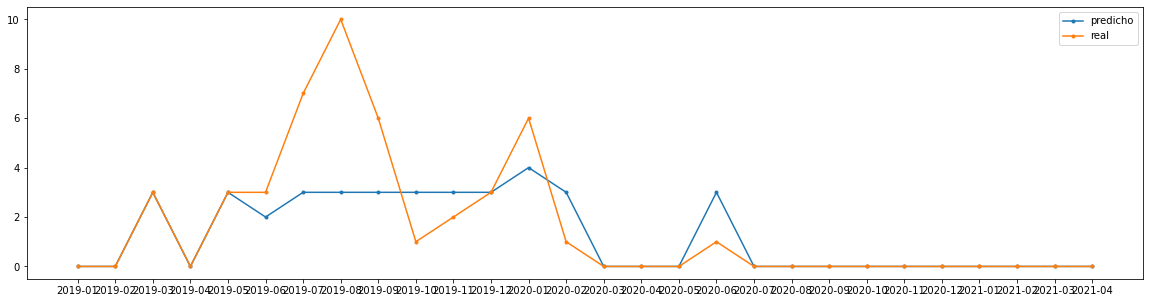

In [15]:
def plot_by_ref_tienda(ref,tienda):
    aux=df.query('REF==@ref & TIENDA==@tienda')
    plt.figure(figsize=(20,5))
    plt.plot(aux['DATE'],aux['PREDICTED'],label='predicho',marker='.')
    plt.plot(aux['DATE'],aux['CANTIDAD'],label='real',marker='.')
    plt.legend()
plot_by_ref_tienda('XA0539:00061:','PUNTO DE VENTA AV 68')


In [16]:
mse(res_test['PREDICTED'],res_test['CANTIDAD'])

2.3290103750997604

'd-a'

In [17]:
aux = res.query('REF=="XA0539:00061:"')
fig = go.Figure()
fig.add_scatter(x=aux['DATE'], y=aux['PREDICTED'], mode='lines+markers', name='Valores predichos')
fig.add_scatter(x=aux['DATE'], y=aux['CANTIDAD'], mode='lines+markers', name='Valores reales')
fig.add_vline(x=date_index, line_width=3, line_dash="dot", line_color="green"
                ,y0=-2,y1=max([aux['PREDICTED'].max(),aux['CANTIDAD'].max()])+1)
fig.add_annotation(x='-'.join([date_indeaf,'5']), y=max([aux['PREDICTED'].max(),aux['CANTIDAD'].max()]),
            text="Test",
            font=dict(
            family="Courier New, monospace",
            size=16,
            color="black"
            ),
            showarrow=True,
            arrowhead=1,
            ax=35,
            ay=0,
            xanchor="center",
            yanchor="middle",)
fig.add_annotation(x='-'.join([date_indebef,'25']), y=max([aux['PREDICTED'].max(),aux['CANTIDAD'].max()]),
            text="Train",
            font=dict(
            family="Courier New, monospace",
            size=16,
            color="black"
            ),
            showarrow=True,
            arrowhead=1,
            ax=-40,
            ay=0,
            xanchor="center",
            yanchor="middle",)

fig.add_annotation(x='-'.join([date_indeaf,'31']), y=max([aux['PREDICTED'].max(),aux['CANTIDAD'].max()])/2,
            text="RMSE:<br>{:.2f}".format(mse(res_test.PREDICTED,res_test.CANTIDAD,squared=False)),
            font=dict(
            family="Courier New, monospace",
            size=16,
            color="black"
            ),
            showarrow=False,
            ax=35,
            ay=0,
            )
fig.add_annotation(x='-'.join([date_indebef,'1']), y=max([aux['PREDICTED'].max(),aux['CANTIDAD'].max()])/2,
            text="RMSE:<br>{:.2f}".format(mse(res_train.PREDICTED,res_train.CANTIDAD,squared=False)),
            font=dict(
            family="Courier New, monospace",
            size=16,
            color="black"
            ),
            showarrow=False,
            arrowhead=1,
            ax=-40,
            ay=0,
            xanchor="center",)
fig.update_layout(
    title="Ventas por referencia",
    yaxis_title="Número de ventas",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    ))

In [ ]:
def split_data(prevs):
    prevs.append(var)
    x_cat=data[prevs].astype('category')
    x_cat_dummies=pd.get_dummies(x_cat)

    y = data['CANTIDAD']

    scaler = MinMaxScaler()
    x_num_norm = scaler.fit_transform(x_num)
    x = np.append(x_num_norm,x_cat_dummies,axis=1)

    #split data till januar 2021
    index = data[(data.ANIO==2021)].index[0]

    x_train = x[:index-1]
    y_train = y[:index-1]
    x_test = x[index-1:]
    y_test = y[index-1:]
    
    return x_train,y_train,x_test,y_test,prevs
    
def fit_model(x_train,y_train):
    model = GradientBoostingRegressor(**{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 300})
    model.fit(x_train,y_train)
    
    return model
    
def get_mse(model,x_test,y_test):
    return mse(model.predict(x_test),y_test)

In [ ]:
data = DataManager().sales_ref_month_sin_ventas_mayores()

num_var=['AREA','ALTO','DESCUENTO(%)','PRECIO','CANTIDAD']
x_num=data[num_var[:-1]].astype('float')

cat_var=[
    'ANIO', 'MES', 'TIENDA', 'PUESTOS', 'COLOR_POS', 'CATEGORIA', 'SUBCATEGORIA_POS', 'VIGENCIA',
    'ORIGEN', 'ESTILO', 'MATERIAL_POS', 'ACABADO', 'F_COVID', 'REF'
]

x_train,y_train,x_test,y_test,prevs = split_data(cat_var)
%time model = fit_model(x_train,y_train)
print('MSE for variables:')
print(prevs)
print(get_mse(model,x_test,y_test))
print('--------------------------------------')

In [ ]:
data = DataManager().sales_ref_month_sin_ventas_mayores()
data['DATE'] = data['ANIO'].astype(str) + '-' + data['MES'].astype(str).str.zfill(2)

num_var=['AREA','ALTO','DESCUENTO(%)','PRECIO','CANTIDAD']
x_num=data[num_var[:-1]].astype('float')

cat_var=[
    'ANIO', 'MES', 'TIENDA', 'PUESTOS', 'COLOR_POS', 'SUBCATEGORIA_POS', 'ESTILO', 'F_COVID' 
]

x_train,y_train,x_test,y_test,prevs = split_data(cat_var)
%time model = fit_model(x_train,y_train)
print('MSE for variables:')
print(prevs)
print(get_mse(model,x_test,y_test))
print('--------------------------------------')

In [ ]:
data['PREDICTED'] = model.predict(np.concatenate([x_train,x_test],axis=0)).round()
data = data.groupby(['REF','DATE']).sum().reset_index()

In [ ]:
aux = data.query('REF=="D00935:00048:00048"')
fig = go.Figure()
fig.add_scatter(x=aux['DATE'], y=aux['PREDICTED'], mode='lines', name='Valores predichos')
fig.add_scatter(x=aux['DATE'], y=aux['CANTIDAD'], mode='lines', name='Valores reales')